In [1]:
import numpy as np
import bisect

from matplotlib import pyplot as plt

In [2]:
from pixel2d import Pixel2D

In [3]:
from topologicalunionfind import TopologicalUnionFind

### Reading Slice

In [4]:
aslice = np.array([[1,3,8], [5,7,6], [9,4,2]])
aslice

array([[1, 3, 8],
       [5, 7, 6],
       [9, 4, 2]])

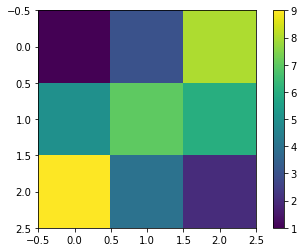

In [5]:
plt.imshow(aslice)
plt.colorbar()
plt.show()

### Getting Data

In [13]:
reverse = False
diagonal = True

In [14]:
if reverse:
    data = aslice.max() - aslice + 1
else:
    data = aslice
data.shape

(3, 3)

### Generating Input File

In [15]:
if reverse: 
    if diagonal:
        ainput = 'toy2dr.txt'
    else:
        ainput = 'toy2dr2.txt'
else:
    if diagonal:
        ainput = 'toy2d.txt'
    else:
        ainput = 'toy2d2.txt'

In [16]:
if diagonal:
    with open(ainput, 'w') as f:
        f.write(str(len(data.shape))+'\n')
        for l in data.shape:
            f.write(str(l)+'\n')
        for i in data.flatten():
            f.write(str(i)+'\n')

In [10]:
if not diagonal:
    with open(ainput, 'w') as f:
        f.write(str(len(data.shape))+'\n')
        for i in range(0, data.shape[0]):
            for j in range(0, data.shape[1]):
                f.write('0 {} {} {}\n'.format(i, j, data[i, j]))
                if i+1<data.shape[0]:
                    f.write('1 {} {} {} {} {}\n'.format(i, j, i+1, j, max(data[i, j], data[i+1, j])))
                if j+1<data.shape[1]:
                    f.write('1 {} {} {} {} {}\n'.format(i, j, i, j+1, max(data[i, j], data[i, j+1])))

### Running

In [11]:
import subprocess

In [12]:
if diagonal:
    subprocess.run(['./perseusMac', 'cubtop', ainput, ainput[:-4]])
else:
    subprocess.run(['./perseusMac', 'nmfsimtop', ainput, ainput[:-4]])

### Reading Output File

In [13]:
if reverse: 
    if diagonal:
        aoutput = 'toy2dr_0.txt'
    else:
        aoutput = 'toy2dr2_0.txt'
else:
    if diagonal:
        aoutput = 'toy2d_0.txt'
    else:
        aoutput = 'toy2d2_0.txt'

In [14]:
pd2 = []
with open(aoutput) as f:
    for l in f.readlines():
        info = l.split()
        pd2.append((int(info[0]), int(info[1])))
pd2 = sorted(pd2, key=lambda x:x[0])
pd2

[(1, -1), (2, 5), (3, 4)]

### Creating Pixel Objects

In [15]:
mat = []
for i in range(data.shape[0]):
    row = []
    for j in range(data.shape[1]):
        element = data[i][j]
        row.append(Pixel2D(i, j, element))
    mat.append(row)

In [16]:
arr = sorted([e for row in mat for e in row])
arr

[Pixel: [coordinates: (2, 0); value: 1],
 Pixel: [coordinates: (0, 2); value: 2],
 Pixel: [coordinates: (1, 1); value: 3],
 Pixel: [coordinates: (1, 2); value: 4],
 Pixel: [coordinates: (1, 0); value: 5],
 Pixel: [coordinates: (2, 1); value: 6],
 Pixel: [coordinates: (0, 1); value: 7],
 Pixel: [coordinates: (2, 2); value: 8],
 Pixel: [coordinates: (0, 0); value: 9]]

### Getting Neighbors for a Pixel

In [17]:
def append2DNeighbor(neighbors, x, y):
    if x < 0 or y < 0:
        return
    try:
        neighbors.append(mat[x][y])
    except:
        pass

In [18]:
def get_neighbors(pixel, diagonal=False):
    neighbors = []
    x = pixel.getX()
    y = pixel.getY()
    append2DNeighbor(neighbors, x-1, y)
    append2DNeighbor(neighbors, x+1, y)
    append2DNeighbor(neighbors, x, y-1)
    append2DNeighbor(neighbors, x, y+1)
    if diagonal:
        append2DNeighbor(neighbors, x-1, y-1)
        append2DNeighbor(neighbors, x-1, y+1)
        append2DNeighbor(neighbors, x+1, y-1)
        append2DNeighbor(neighbors, x+1, y+1)
    return neighbors

In [19]:
set([len(get_neighbors(pixel)) for pixel in arr])

{2, 3, 4}

In [20]:
set([len(get_neighbors(pixel, True)) for pixel in arr])

{3, 5, 8}

### Creating Topological Union-find

In [21]:
tuf = TopologicalUnionFind()
tuf

<UnionFind:
	elts=[],
	siz=[],
	par=[],
n_elts=0,n_comps=0>

In [22]:
for pixel in arr:
    tuf.add(pixel, pixel.getV())
    for neighbor in get_neighbors(pixel, diagonal):
        tuf.union(pixel, neighbor, pixel.getV())

In [23]:
pd = tuf.persistence_diagram()
pd

[(Pixel: [coordinates: (2, 0); value: 1], 1, inf),
 (Pixel: [coordinates: (0, 2); value: 2], 2, 5),
 (Pixel: [coordinates: (1, 1); value: 3], 3, 4)]

### Visualization

In [24]:
y = np.arange(0, len(pd))

In [25]:
xmin = [f[1] for f in pd]
xmax = [data.max()*1.1 if np.isinf(f[2]) else f[2] for f in pd]
xlim = (min(xmin), max(xmax))

In [26]:
if reverse:
    xmin, xmax = [aslice.max() - x + 1 for x in xmax], [aslice.max() - x + 1 for x in xmin]
    xlim = (max(xmax), min(xmin))

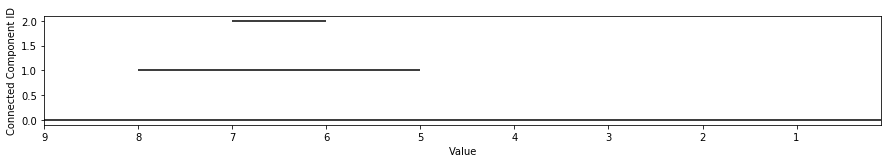

In [27]:
height = 2 + len(pd) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

### Visualization2

In [28]:
y = np.arange(0, len(pd2))

In [29]:
xmin = [f[0] for f in pd2]
xmax = [data.max()*1.1 if f[1] == -1 else f[1] for f in pd2]
xlim = (min(xmin), max(xmax))

In [30]:
if reverse:
    xmin, xmax = [aslice.max() - x + 1 for x in xmax], [aslice.max() - x + 1 for x in xmin]
    xlim = (max(xmax), min(xmin))

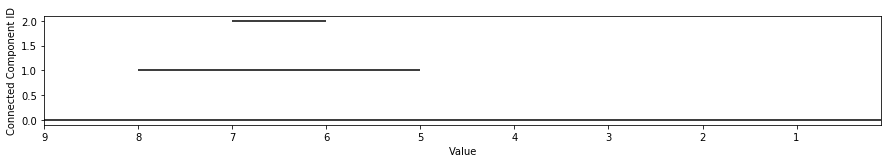

In [31]:
height = 2 + len(pd2) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()